In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import re
import os
from pathlib import Path

In [2]:

def parse_log_file(path):
    iteration_pattern = re.compile(r'ITERATION\s+(\d+)\b')
    method_completion_pattern = re.compile(r'Method\s+([^\s]+)\s+completed\s+in\s+([\d.]+)\s+seconds')
    test_script_pattern = re.compile(r'Test script invocation completed in\s+([\d.]+)\s+seconds')
    total_time_pattern = re.compile(r'Execution time:\s*([\d.]+)\s+seconds')  # if present
    
    data = {}  # iteration -> method -> {'count': int, 'time': float}
    current_iter = None

    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            # detect iteration header
            m_iter = iteration_pattern.search(line)
            if m_iter:
                current_iter = int(m_iter.group(1))
                if current_iter not in data:
                    data[current_iter] = defaultdict(lambda: {'count': 0, 'time': 0.0})
                continue
            if current_iter is None:
                continue  # skip before any iteration found

            m_method = method_completion_pattern.search(line)
            if m_method:
                name = m_method.group(1)
                t = float(m_method.group(2))
                entry = data[current_iter][name]
                entry['count'] += 1
                entry['time'] += t
                continue
            m_test = test_script_pattern.search(line)
            if m_test:
                t = float(m_test.group(1))
                entry = data[current_iter]['test_script']
                entry['count'] += 1
                entry['time'] += t
                continue
            # optionally capture other total times if present
            m_total = total_time_pattern.search(line)
            if m_total:
                entry = data[current_iter]['total_execution']
                entry['count'] += 1
                entry['time'] += float(m_total.group(1))
    return data

def print_summary(data):
    for iteration in sorted(data):
        print(f"\n=== ITERATION {iteration} ===")
        methods = data[iteration]
        total_time = sum(v['time'] for v in methods.values())
        print(f"Aggregate time (sum of all recorded method/test times): {total_time:.6f} seconds")
        for method, info in sorted(methods.items(), key=lambda x: (-x[1]['time'], x[0])):
            print(f"- {method}: count={info['count']}, time={info['time']:.6f}")
            



In [3]:
def plot_pie(data, iteration):
    methods = data[iteration]
    df = pd.DataFrame([
        {'method': k, 'count': v['count'], 'time': v['time']}
        for k, v in methods.items() if v['time'] > 0
    ])
    if df.empty:
        print(f"Skipping iteration {iteration} (no data).")
        return

    # Plot
    plt.figure(figsize=(8, 8))
    plt.pie(df['time'], labels=df['method'], autopct='%1.1f%%', startangle=140)
    plt.title(f'Iteration {iteration} - Time Distribution')
    plt.tight_layout()
    plt.show()


In [4]:
path = '/Users/artemancikov/Desktop/practical-work-new/full_remove_output.log'


In [5]:
def clean_data(data):
    for iteration in data:
        methods = data[iteration]
        keys_to_remove = [k for k in methods if k.startswith("remove_nodes") or k == "total_execution"]
        for k in keys_to_remove:
            del methods[k]


In [6]:
def plot_bar(data, iteration):
    methods = data[iteration]
    df = pd.DataFrame([
        {'method': k, 'count': v['count'], 'time': v['time']}
        for k, v in methods.items() if v['time'] > 0
    ])
    if df.empty:
        print(f"Skipping iteration {iteration} (no data).")
        return

    df = df.sort_values(by='time', ascending=False)

    plt.figure(figsize=(10, max(4, len(df) * 0.4)))
    plt.barh(df['method'], df['time'])
    plt.xlabel("Total Time (s)")
    plt.title(f"Iteration {iteration} - Time by Method")
    plt.gca().invert_yaxis()  # most time on top
    plt.tight_layout()
    plt.show()


In [7]:
def plot_all_iterations(data):
    for iteration in sorted(data.keys()):
        plot_bar(data, iteration)


In [8]:
data = parse_log_file(path)
clean_data(data)

#print_summary(data)
#plot_all_iterations(data)

In [9]:
def plot_total_time_across_iterations(data):
    # Aggregate time per method across all iterations
    aggregate = defaultdict(float)
    for methods in data.values():
        for method, stats in methods.items():
            aggregate[method] += stats['time']

    if not aggregate:
        print("No data to plot.")
        return

    df = pd.DataFrame([
        {'method': k, 'time': v}
        for k, v in aggregate.items() if v > 0
    ])
    df = df.sort_values(by='time', ascending=False)

    plt.figure(figsize=(10, max(4, len(df) * 0.4)))
    plt.barh(df['method'], df['time'])
    plt.xlabel("Total Time (s)")
    plt.title("Total Time per Method (All Iterations)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


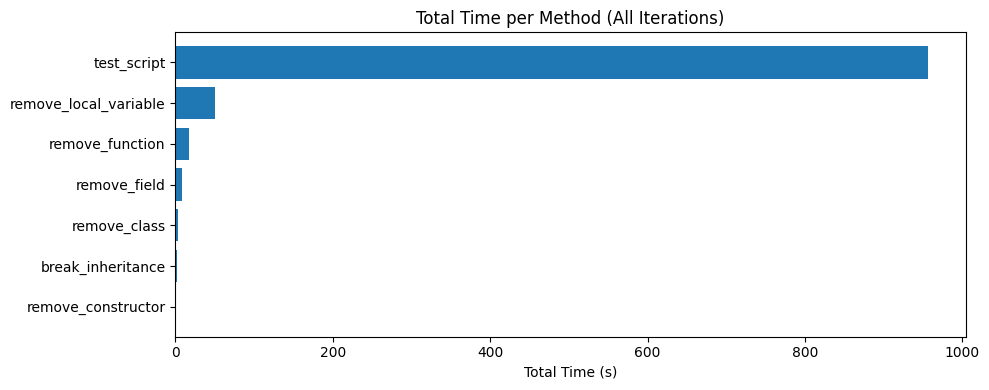

In [10]:
plot_total_time_across_iterations(data)


In [11]:
def print_total_time_percentages(data):
    # Aggregate total time per method
    total_by_method = defaultdict(float)
    total_all = 0.0

    for methods in data.values():
        for method, stats in methods.items():
            total_by_method[method] += stats['time']
            total_all += stats['time']

    if total_all == 0:
        print("No time data found.")
        return

    print("\n=== Total Time Percentage per Method ===")
    for method, time in sorted(total_by_method.items(), key=lambda x: -x[1]):
        percent = (time / total_all) * 100
        print(f"{method:30} {time:10.6f} sec  ({percent:5.2f}%)")


In [12]:
print_total_time_percentages(data)



=== Total Time Percentage per Method ===
test_script                    956.281328 sec  (92.17%)
remove_local_variable           50.416321 sec  ( 4.86%)
remove_function                 16.985464 sec  ( 1.64%)
remove_field                     8.102562 sec  ( 0.78%)
remove_class                     3.018545 sec  ( 0.29%)
break_inheritance                2.288024 sec  ( 0.22%)
remove_constructor               0.375899 sec  ( 0.04%)


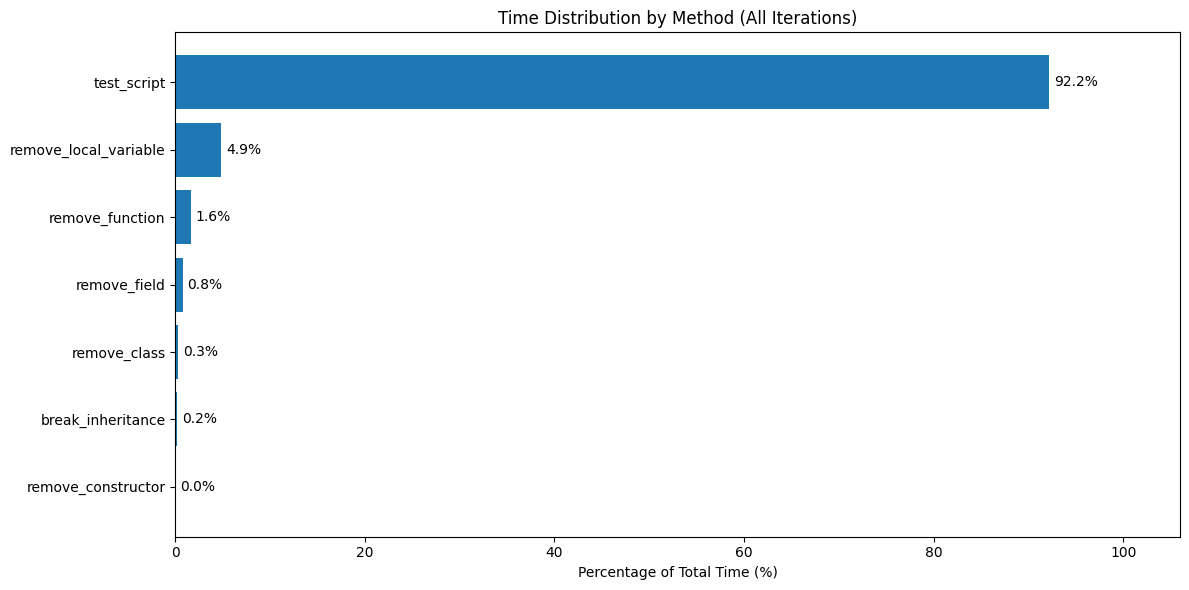

In [13]:
def plot_total_time_percentages_bar(data):
    # Aggregate total time per method
    total_by_method = defaultdict(float)
    total_all = 0.0

    for methods in data.values():
        for method, stats in methods.items():
            total_by_method[method] += stats['time']
            total_all += stats['time']

    if total_all == 0:
        print("No time data found.")
        return

    # Create DataFrame and sort by time
    df = pd.DataFrame([
        {'method': method, 'time': time, 'percentage': (time / total_all) * 100}
        for method, time in total_by_method.items()
    ])
    df = df.sort_values(by='percentage', ascending=False)

    # Create bar plot
    plt.figure(figsize=(12, max(6, len(df) * 0.5)))
    bars = plt.barh(df['method'], df['percentage'])
    
    # Add percentage labels on bars
    for i, (bar, percentage) in enumerate(zip(bars, df['percentage'])):
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{percentage:.1f}%', va='center', ha='left')
    
    plt.xlabel("Percentage of Total Time (%)")
    plt.title("Time Distribution by Method (All Iterations)")
    plt.gca().invert_yaxis()  # highest percentage on top
    plt.xlim(0, df['percentage'].max() * 1.15)  # add space for labels
    plt.tight_layout()
    plt.show()

# Call the function
plot_total_time_percentages_bar(data)

In [15]:
import os
from pathlib import Path

def create_run_scripts():
    # Base directory
    base_dir = Path("/Users/artemancikov/Desktop/practical-work-new/reducer/generator_source2")
    
    # Template for run.sh
    template = '''#!/bin/bash
start_time=$(date +%s)

source_file=$(find . -maxdepth 1 -name "*.java" | head -n 1)
expected_error="{expected_error}"
expected_count=1

if [ ! -f "$source_file" ]; then
    echo "Error: Could not find Java file in working directory."
    exit 1
fi

javac "$source_file" 2> compile_err.txt
count=$(grep -o "$expected_error" compile_err.txt | wc -l | xargs)
total_errors=$(grep -c "error:" compile_err.txt)

if [ "$count" -eq "$expected_count" ] && [ "$total_errors" -eq "$expected_count" ]; then
    exit 0
else
    exit 1
fi
'''

    # Find all directories starting with "iter_"
    iter_dirs = [d for d in base_dir.iterdir() if d.is_dir() and d.name.startswith("iter_")]
    
    for iter_dir in sorted(iter_dirs):
        # Read the expected_error from error.txt if it exists
        error_file = iter_dir / "error.txt"
        if error_file.exists():
            with open(error_file, 'r') as f:
                expected_error = f.read().strip()
        else:
            # Default error if error.txt doesn't exist
            expected_error = "cannot find symbol"
        
        # Create run.sh content with the expected error
        run_sh_content = template.format(expected_error=expected_error)
        
        # Write run.sh file
        run_sh_path = iter_dir / "run.sh"
        with open(run_sh_path, 'w') as f:
            f.write(run_sh_content)
        
        # Make the script executable
        os.chmod(run_sh_path, 0o755)
        
        print(f"Created {run_sh_path} with expected_error: '{expected_error}'")

# Run the function
create_run_scripts()

Created /Users/artemancikov/Desktop/practical-work-new/reducer/generator_source2/iter_1/run.sh with expected_error: 'cannot find symbol'
Created /Users/artemancikov/Desktop/practical-work-new/reducer/generator_source2/iter_10/run.sh with expected_error: 'cannot find symbol'
Created /Users/artemancikov/Desktop/practical-work-new/reducer/generator_source2/iter_2/run.sh with expected_error: 'cannot find symbol'
Created /Users/artemancikov/Desktop/practical-work-new/reducer/generator_source2/iter_3/run.sh with expected_error: 'cannot find symbol'
Created /Users/artemancikov/Desktop/practical-work-new/reducer/generator_source2/iter_4/run.sh with expected_error: 'cannot find symbol'
Created /Users/artemancikov/Desktop/practical-work-new/reducer/generator_source2/iter_5/run.sh with expected_error: 'cannot find symbol'
Created /Users/artemancikov/Desktop/practical-work-new/reducer/generator_source2/iter_6/run.sh with expected_error: 'cannot find symbol'
Created /Users/artemancikov/Desktop/prac